# Improving the Performance of Machine Learning Predictors


### Objectives:
    
- Practise machine learning optimisation techniques including GridSearchCV and dimensionality reduction

- Use feature importance to identify features that the model considers of high importance that are related to the classification of two groups

- Use feature selection to isolate features related to the classification of two groups

- Use a deep learning model implemented in Pytorch to separate encoded amino acid sequences



When a machine learning predictor is performing well, or not so well, there is always the possibility of improving its performance. This second part of the exercise will focus on techniques to achieve this performance increase. The first method we will explore is model hyperparameterisation. This means editing the model's parameters until a maximum score and optimisation are reached. Secondly we can increase performance by selecting features in the data which can allow patterns to be more easily trained upon, thus reducing the signal to noise ratio in the data. Finally, we will look at combining features with dimensionality reduction.

N.B. You should have completed the first part of the exercise to understand antibody VH/VL pairing and to generate the encoded dataset CSVs that will be needed in this exercise

## Imports

In [99]:
RANDOM_SEED = 42


##Import data preparation modules###
from sklearn.utils import check_random_state, shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import numpy as np
from numpy import mgrid, linspace, c_, arange, mean, array
import sys
import pandas as pd
from pandas import read_csv
import pickle



##Import machine learning models###
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis



##Import plotting results###
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits import mplot3d
from matplotlib.pyplot import subplots, axes, scatter, xticks
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
import matplotlib.patches as mpatches



##Import model optimisation###
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


## Load Previously Trained Models

To demonstrate that the previously trained models can be loaded from another script, the current workbook will split the test and train data the same way as the previous script by using the same random seed as before, this ensures that the data used to evaluate the scripts is still unseen by the scripts. The Pickle module can be used to load the pretrained models and use them for testing without needing to retrain the models on the test dataset.

In [98]:
##Load previously encoded data and retrain models##
joined_dataframe_VH_VL = read_csv('./HumanMouseOAS_VH_VL_paired_data.faa_Full_descriptors.csv', header = 0)
#Prepare training data and labels
labels1 = 1000*[1] ##Human antibodies will be class 1
labels2 = 1000*[0] ## Mouse antibodies will be class 0
y = labels1+labels2
dataset = joined_dataframe_VH_VL
dataset=dataset.loc[:, dataset.columns != 'Unnamed: 0']


#Train/test split using same random seed as defined above#
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=.3, random_state=RANDOM_SEED, shuffle=True)
num_rows, num_cols = dataset.shape
print("Training set size: ", X_train.shape, "       Test set size: ", X_test.shape)



Training set size:  (1400, 890)        Test set size:  (600, 890)


/Users/james/anaconda3/envs/py38-igfold/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/james/anaconda3/envs/py38-igfold/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/james/anaconda3/envs/py38-igfold/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from versio

[Text(0, 0, 'SVC'),
 Text(1, 0, 'SVC2'),
 Text(2, 0, 'DecisionTree'),
 Text(3, 0, 'RFC'),
 Text(4, 0, 'MLPC'),
 Text(5, 0, 'ADABoost'),
 Text(6, 0, 'GaussianNB'),
 Text(7, 0, 'QDA')]

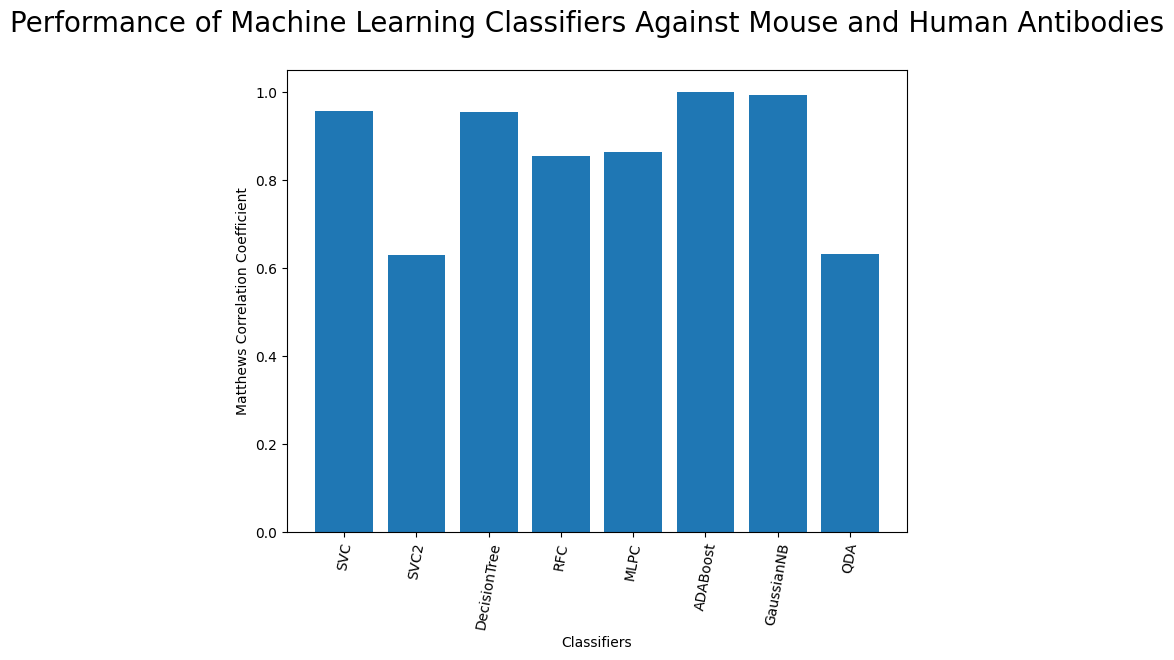

In [101]:
#Define classifiers for looping through#
classifiers = {
    'SVC':SVC(kernel="linear", C=0.025),
    'SVC2': SVC(gamma=2, C=1),
    'DecisionTree': DecisionTreeClassifier(max_depth=5),
    'RFC': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    'MLPC': MLPClassifier(alpha=1, max_iter=1000,random_state=42),
    'ADABoost':AdaBoostClassifier(),
    'GaussianNB': GaussianNB(),
    'QDA':QuadraticDiscriminantAnalysis(),
}

scores = []
#Load previously trained models and use them for predicting the test set#
for i in classifiers:
    filename = f"{i}.pkl"
    with open(filename, 'rb') as file:
        model = pickle.load(file)
        y_predict = model.predict(X_test)
        scoring    = matthews_corrcoef(y_test, y_predict)
        scores.append(scoring)
        
##Plot Performance of all Models as bar chart##
fig, ax = plt.subplots(figsize=(8,6))
plt.suptitle('Performance of Machine Learning Classifiers Against Mouse and Human Antibodies', fontsize=20)
bins = arange(len(classifiers))
ax.bar(arange(len(scores)), scores)
ax.set_ylabel('Matthews Correlation Coefficient')
ax.set_xlabel('Classifiers')
ax.set_xticks(bins)
ax.set_xticklabels(classifiers, rotation=80)

        

You should notice that this data is the same as what was trained in the previous script using the same train/test split of the amino acid sequences encoded by physicochemical properties. Hopefully this has given an appreciation how to save and load models. As can be seen, there is still poorer performance in the SVC2 and QDA models, as well as a marginally poor performance in the MLPC and RFC models. The next passages will look to improve this performance.

## GridSearchCV
This is usually done through either GridSearchCV, which does this using a reference grid and systematically compares each combination with every other; or RandomSearchCV - which is more stochastic and, instead, samples from ranges which may be applied to each parameter. Here we will apply the GridSearchCV on both the SVC2 and RandomForestClassifier predictor, in order to try and increase its performance on our dataset.

It is important to know that not all classifiers have the capacity for GridSearchCV.

N.B. These processes will likely take a few minutes.

In [102]:
##GridsearchCV of SVC2 Model####
param_grid = {'C':[1],
              'gamma':[1,0.001],
}
##Instantiate SVC model
svc = SVC()

# Instantiate the grid search model and fit training data to model with best set of hyperparameters
svc_grid_search = GridSearchCV(estimator = svc, param_grid=  param_grid,
                               refit = True, n_jobs = -1,verbose = 2)
svc_grid_search.fit(X_train,y_train)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[CV] END .......................................C=1, gamma=1; total time=   1.6s
[CV] END ...................................C=1, gamma=0.001; total time=   1.5s
[CV] END ...................................C=1, gamma=0.001; total time=   1.6s
[CV] END .......................................C=1, gamma=1; total time=   1.6s
[CV] END .......................................C=1, gamma=1; total time=   1.6s
[CV] END ...................................C=1, gamma=0.001; total time=   1.6s
[CV] END .......................................C=1, gamma=1; total time=   1.6s
[CV] END .......................................C=1, gamma=1; total time=   1.6s
[CV] END ...................................C=1, gamma=0.001; total time=   0.6s
[CV] END ...................................C=1, gamma=0.001; total time=   0.6s


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1], 'gamma': [1, 0.001]}, verbose=2)

In [103]:
##GridsearchCV of MLPC Model####
param_grid = {
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
# Instantiate a MLPC model
mlpc = MLPClassifier()

# Instantiate the grid search model and fit training data to model with best set of hyperparameters
mlpc_grid_search = GridSearchCV(estimator = mlpc, param_grid = param_grid, 
                          refit = True, cv = 3, n_jobs = -1, verbose = 2)
mlpc_grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END activation=tanh, alpha=0.0001, learning_rate=adaptive; total time=   0.5s
[CV] END activation=tanh, alpha=0.0001, learning_rate=adaptive; total time=   0.6s
[CV] END activation=tanh, alpha=0.0001, learning_rate=constant; total time=   0.7s
[CV] END activation=tanh, alpha=0.0001, learning_rate=constant; total time=   0.8s
[CV] END activation=tanh, alpha=0.0001, learning_rate=adaptive; total time=   1.0s
[CV] END activation=tanh, alpha=0.0001, learning_rate=constant; total time=   1.0s
[CV] END activation=tanh, alpha=0.05, learning_rate=constant; total time=   1.1s
[CV] END activation=tanh, alpha=0.05, learning_rate=constant; total time=   1.2s
[CV] END activation=tanh, alpha=0.05, learning_rate=constant; total time=   1.2s
[CV] END activation=tanh, alpha=0.05, learning_rate=adaptive; total time=   1.0s
[CV] END activation=tanh, alpha=0.05, learning_rate=adaptive; total time=   1.3s
[CV] END activation=tanh, alpha=0.05,

GridSearchCV(cv=3, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'learning_rate': ['constant', 'adaptive']},
             verbose=2)

In [104]:
##GridsearchCV of QDA Model####
confusion_matrices = []
param_grid = {'reg_param': [0.1, 0.2, 0.3, 0.4, 0.5]}
# Instantiate QDA model
qda = QuadraticDiscriminantAnalysis()

# Instantiate the grid search model and fit training data to model with best set of hyperparameters
qda_grid_search = GridSearchCV(estimator = qda, param_grid = param_grid, 
                          refit = True, cv = 3, n_jobs = -1, verbose = 2)
qda_grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


/Users/james/anaconda3/envs/py38-igfold/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/james/anaconda3/envs/py38-igfold/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/james/anaconda3/envs/py38-igfold/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/james/anaconda3/envs/py38-igfold/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/james/anaconda3/envs/py38-igfold/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/james/anaconda3/envs/py38-igfold/lib/python3.8/site-packages/sk

[CV] END ......................................reg_param=0.2; total time=   0.4s
[CV] END ......................................reg_param=0.2; total time=   0.4s
[CV] END ......................................reg_param=0.1; total time=   0.4s
[CV] END ......................................reg_param=0.3; total time=   0.4s
[CV] END ......................................reg_param=0.3; total time=   0.4s
[CV] END ......................................reg_param=0.1; total time=   0.5s
[CV] END ......................................reg_param=0.2; total time=   0.4s
[CV] END ......................................reg_param=0.1; total time=   0.5s


/Users/james/anaconda3/envs/py38-igfold/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/james/anaconda3/envs/py38-igfold/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/james/anaconda3/envs/py38-igfold/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/james/anaconda3/envs/py38-igfold/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/james/anaconda3/envs/py38-igfold/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/james/anaconda3/envs/py38-igfold/lib/python3.8/site-packages/sk

[CV] END ......................................reg_param=0.3; total time=   0.3s
[CV] END ......................................reg_param=0.5; total time=   0.3s
[CV] END ......................................reg_param=0.4; total time=   0.4s
[CV] END ......................................reg_param=0.4; total time=   0.4s
[CV] END ......................................reg_param=0.4; total time=   0.4s
[CV] END ......................................reg_param=0.5; total time=   0.3s
[CV] END ......................................reg_param=0.5; total time=   0.4s


/Users/james/anaconda3/envs/py38-igfold/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


GridSearchCV(cv=3, estimator=QuadraticDiscriminantAnalysis(), n_jobs=-1,
             param_grid={'reg_param': [0.1, 0.2, 0.3, 0.4, 0.5]}, verbose=2)

Let's plot some additional confusion matrices to check if these classifiers are working better after GridsearchCV

In [105]:
##Plot SVC GRID SEARCH CONFUSION MATRIX###
print(svc_grid_search.best_params_) ##Print the parameters which achieved the best score
y_predict1 = svc_grid_search.predict(X_test)
svc_grid_search_scoring = matthews_corrcoef(y_test, y_predict1)
cf_matrix1 = metrics.confusion_matrix(y_test, y_predict1)
confusion_matrices.append(cf_matrix1)



{'C': 1, 'gamma': 0.001}


In [106]:
##Plot MLPC GRID SEARCH CONFUSION MATRIX###

print(mlpc_grid_search.best_params_) ##Print the parameters which achieved the best score
y_predict1 = mlpc_grid_search.predict(X_test)
mlpc_grid_search_scoring = matthews_corrcoef(y_test, y_predict1)
cf_matrix1 = metrics.confusion_matrix(y_test, y_predict1)
confusion_matrices.append(cf_matrix1)


{'activation': 'relu', 'alpha': 0.0001, 'learning_rate': 'adaptive'}


In [107]:
##Plot QDA GRID SEARCH CONFUSION MATRIX###

print(qda_grid_search.best_params_) ##Print the parameters which achieved the best score
y_predict1 = qda_grid_search.predict(X_test)
qda_grid_search_scoring = matthews_corrcoef(y_test, y_predict1)
cf_matrix1 = metrics.confusion_matrix(y_test, y_predict1)
confusion_matrices.append(cf_matrix1)


{'reg_param': 0.1}


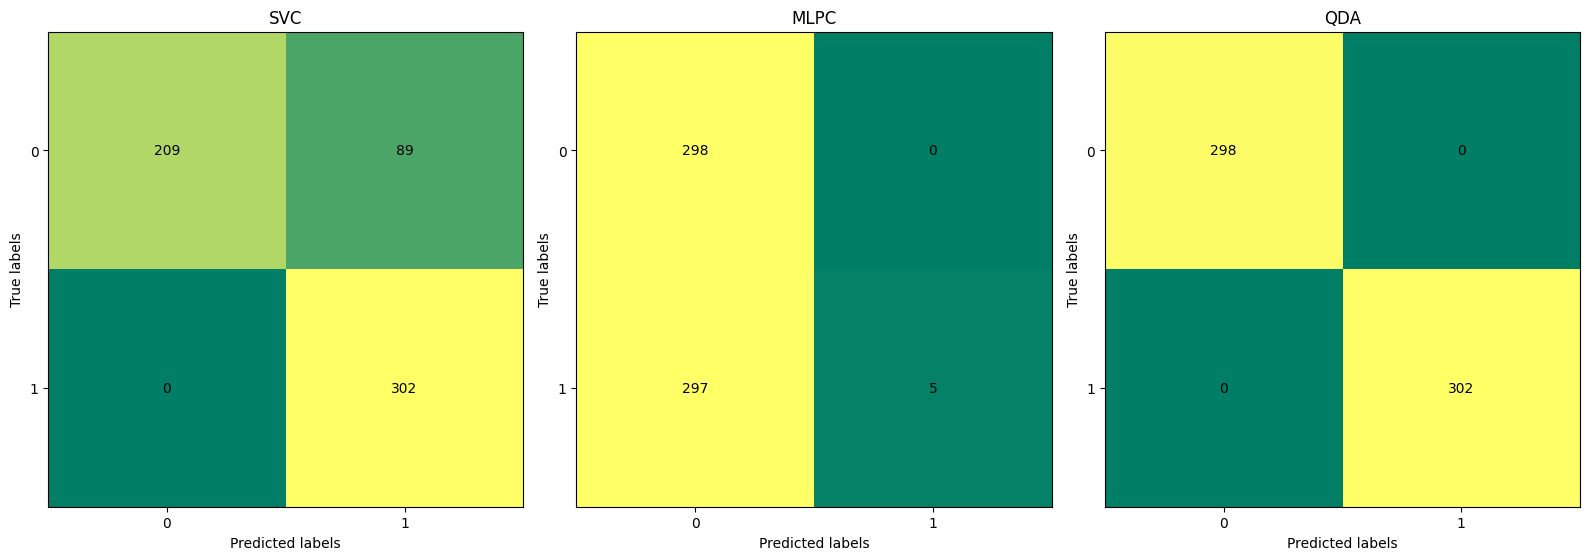

In [108]:
#Plot confusion matrices of newly plotted confusion matrices#
fig, axes = plt.subplots(1, 3, figsize=(16, 8))
class_labels = ["0","1"]
titles = ["SVC","MLPC","QDA"]

# Plot confusion matrices
for i, ax in enumerate(axes.flat):
    ax.imshow(confusion_matrices[i], cmap='summer')
    ax.set_title(titles[i])
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.grid(False)
    ax.set_xticks(np.arange(len(class_labels)))
    ax.set_yticks(np.arange(len(class_labels)))
    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels)
    

    # Annotate numerical values
    for j in range(confusion_matrices[i].shape[0]):
        for k in range(confusion_matrices[i].shape[1]):
            ax.text(k, j, f'{confusion_matrices[i][j, k]}', ha='center', va='center', color='black')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

We can also compare the old MCC score to the new one and see how they have improved for ourselves.

[0.9568024361006595, 0.6277809124006923, 0.9534118843772501, 0.8540491276976634, 0.8618507569685878, 1.0, 0.9933548194098571, 0.6303765610812693]


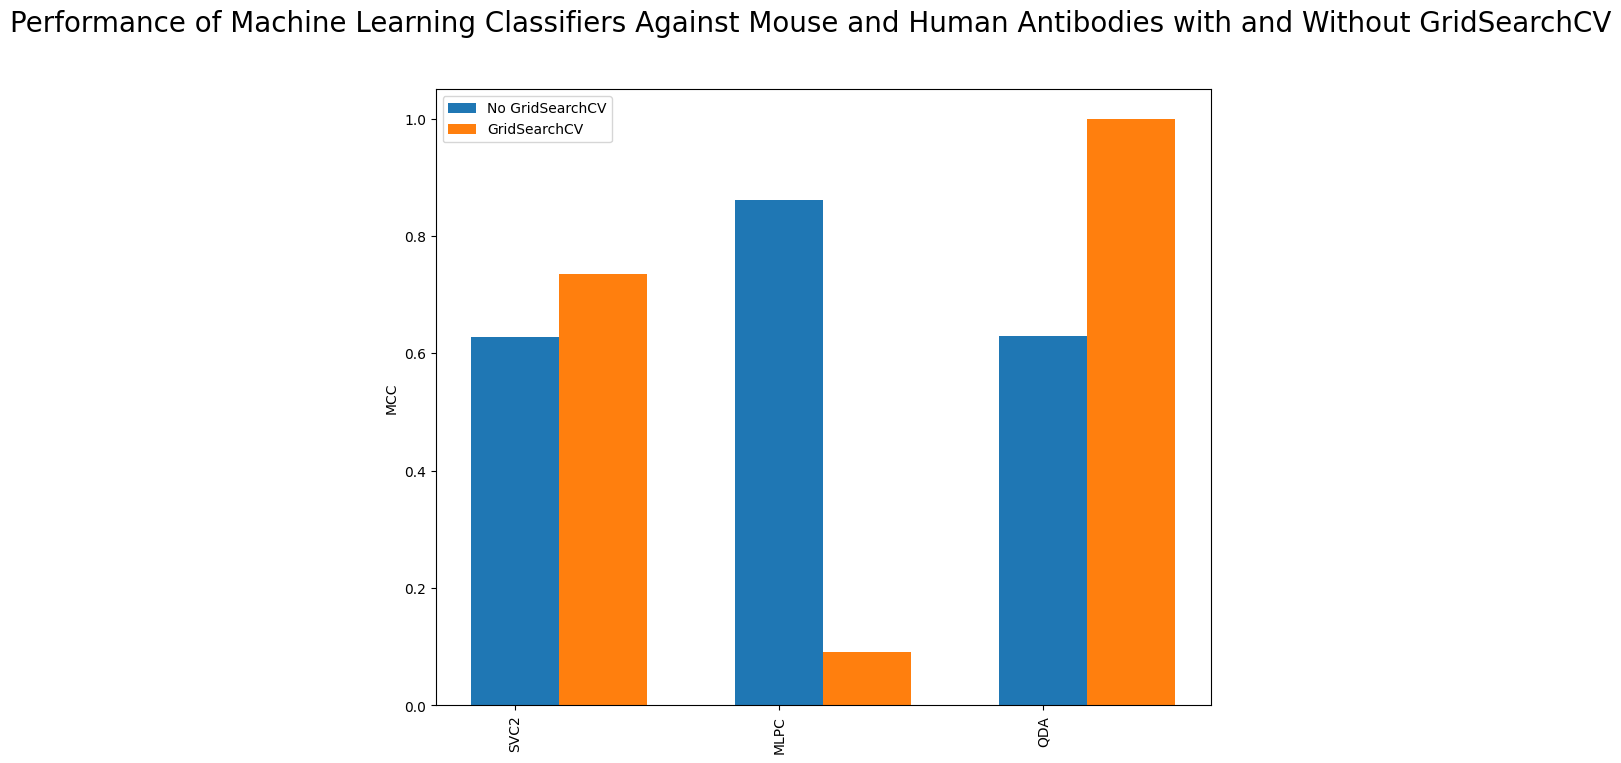

In [109]:
##Plot MCC values of SVC and RFC Models with and without GridsearchCV##
import numpy as np 
import matplotlib.pyplot as plt
print(scores)
classifiers2 = ["SVC2","MLPC","QDA"]
no_grid_scores = [scores[1],scores[4],scores[7]]
grid_scores = [svc_grid_search_scoring, mlpc_grid_search_scoring,qda_grid_search_scoring] 
labels = classifiers2
aranged = np.arange(len(classifiers2)) 
width = 1/3

fig, ax = plt.subplots(figsize=(10,8))


bar1 = plt.bar(aranged, no_grid_scores, width,label = 'No GridSearchCV')
bar2 = plt.bar(aranged+width, grid_scores , width,label = 'GridSearchCV')

plt.suptitle('Performance of Machine Learning Classifiers Against Mouse and Human Antibodies with and Without GridSearchCV', fontsize=20)
ax.set_ylabel('MCC')
ax.set_xticks(aranged, labels, rotation = 90)
ax.legend()


plt.legend()
plt.show()

We can see that the performance of all of the classifiers has changedfor all classifiers tested with this method. However, reults of this test may change over successive runs due to the stochastic nature of the algorithm, or depending on the parameters used, so bear this in mind.

## Do it yourself

- GridSearchCV is not the only kind of hyperparameter optimisation technique. RandomizedSearchCV is similar to GridSearchCV but instead of iterating over every combination of specified parameter, it randomly samples intervals for for a given number of iterations and notes which settings score the best. Documentation can be found here: https://scikit-learn.org/stable/supervised_learning.html

- Try optimising the MLPC with RandomizedSearchCV instead and see if this improves performance.

## Feature Importance

Some classifiers have functions where features with high importance can be ranked. A Random Forest Classifier has a feature importance instance, where the features that contribute most highly to the determination of the classifier may be examined and plotted as percentages of their contribution. Using the best hyperparameters found by the GridSearchCV alogrithm, we may declare a new Random Forest and investigate which features are the most significant.


/var/folders/r7/969c1s5942x9xn1z91z7rvgw0000gn/T/ipykernel_28164/4257255267.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sorted_feature_names[:49], rotation=80)


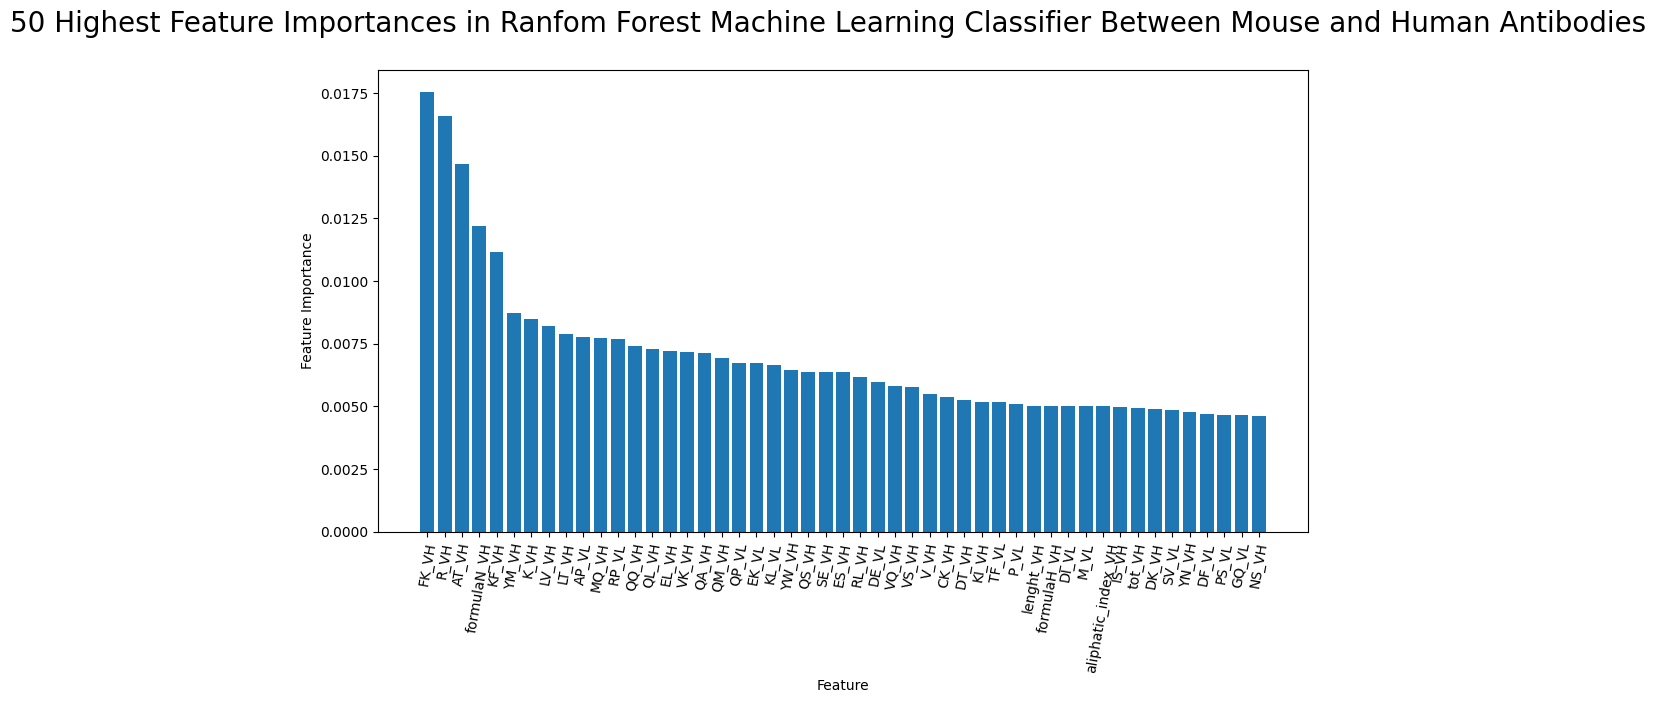

In [110]:
##Get Feature Importance###

#Initialise Random Forest Classifier with best parameters#
RF_Best_Params = RandomForestClassifier(bootstrap= True, max_depth=80, max_features=3, min_samples_leaf= 3, min_samples_split= 10, n_estimators= 100)
#Fit model to training data#
RF_Best_Params.fit(X_train, y_train)
#Get feature importances#
importances  =  RF_Best_Params.feature_importances_
#Sort feature importances decending#
sorted_importances = sorted(importances, reverse=True)
#Get column names as feature names#
feature_names = X_train.columns
#Sort feature names by importance#
sorted_feature_names = [feature_names for _, feature_names in sorted(zip(importances, feature_names), reverse = True)]

#Plot top 50 features#
fig, ax = plt.subplots(figsize=(12,6))
plt.suptitle('50 Highest Feature Importances in Ranfom Forest Machine Learning Classifier Between Mouse and Human Antibodies', fontsize=20)
ax.bar(sorted_feature_names[:49], sorted_importances[:49])
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Feature')
ax.set_xticklabels(sorted_feature_names[:49], rotation=80)
plt.show()

While this has now selected the features which have been most important for prediction, because these are features not explained by the encoding method, it is difficult to see how these relate to the sequences themselves. Perhaps using this technique on a simpler encoding could actually identify residues which are important for distinguishing mouse and human antibodies?


/var/folders/r7/969c1s5942x9xn1z91z7rvgw0000gn/T/ipykernel_28164/251145576.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sorted_feature_names[:49], rotation=80)


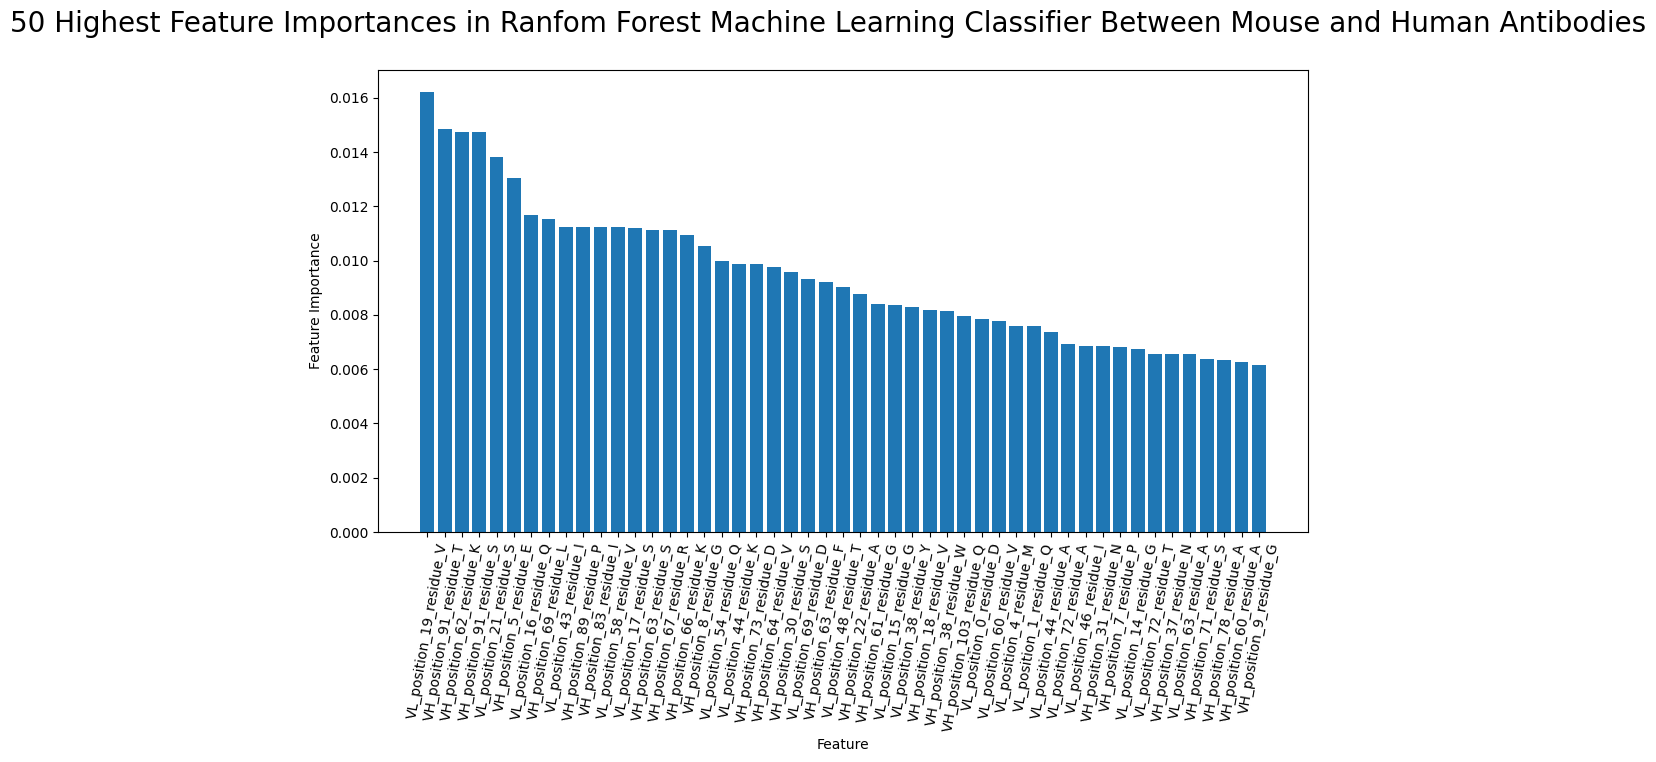

In [111]:

#Load One Hot Encoded Data and get train/test split#
OHE_joined_dataframe_VH_VL = read_csv('./Human_Mouse_VH_VL_OHE.csv',header=0)
X_train_OHE, X_test_OHE, y_train_OHE, y_test_OHE = train_test_split(OHE_joined_dataframe_VH_VL, y, test_size=.3, random_state=RANDOM_SEED, shuffle=True)

#Initialise Random Forest Classifier with best parameters#
RF_Best_Params = RandomForestClassifier(bootstrap= True, max_depth=80, max_features=3, min_samples_leaf= 3, min_samples_split= 10, n_estimators= 100)
#Fit model to training data#
RF_Best_Params.fit(X_train_OHE, y_train_OHE)
#Get feature importances#
importances  =  RF_Best_Params.feature_importances_
#Sort feature importances decending#
sorted_importances = sorted(importances, reverse=True)
#Get column names as feature names#
feature_names = X_train_OHE.columns
#Sort feature names by importance#
sorted_feature_names = [feature_names for _, feature_names in sorted(zip(importances, feature_names), reverse = True)]

#Plot top 50 features#
fig, ax = plt.subplots(figsize=(12,6))
plt.suptitle('50 Highest Feature Importances in Ranfom Forest Machine Learning Classifier Between Mouse and Human Antibodies', fontsize=20)
ax.bar(sorted_feature_names[:49], sorted_importances[:49])
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Feature')
ax.set_xticklabels(sorted_feature_names[:49], rotation=80)
plt.show()

These features give a more clear view on what information is being considered by the model as the most important for determining if a given antibody is mouse or human. However, as can be seen, the relative feature importance scores are still particularly low, indicating that no single feature can definitively determine this, and so a number of features have to be taken into account. Does the performance improve if we just use the most important features?

## Do it yourself
We now have a list of all the feature names sorted by feature importance. By using the code below we can rework our dataframe to the 50 most important features:

`X = X[sorted_feature_names][:49]`

- Try running the classifiers again, but this time use the top 50 features only as your input data. See how that improves each classifier. Are all of them improved?


## Dimensionality Reduction

As an additional task, we can try dimensionality reduction in the event that it might improve the performance of poorer predictors. Principal Component Analysis (PCA) is commonly applied in machine learning as a pre-processing step when dealing with data that contains multiple data points per sample. This increases interpretability of our data, and also allows us to plot it, visually. In short, it works to identify data points that can be grouped together and represented in a vector (principal components) to explain the variability seen in the data. Usually, they are ordered in descending order of how much variability they can explain (e.g. PC1 would explain the most variability, PCn would explain the least).

The PCA model can be applied to the dataset, and see if this changes the performance of the models.


In [112]:
joined_dataframe_VH_VL = read_csv('./Human_Mouse_VH_VL_OHE.csv', header = 0)
dataset = joined_dataframe_VH_VL
dataset=dataset.loc[:, dataset.columns != 'Unnamed: 0']

##Perform PCA 
nComp = 50 #Number of PCs to be returned
threshold = 0.7 #Threshold for cumulative explained variance

#Initialise PCA model#
EncodingPCA = PCA(n_components=nComp, whiten=True)
#Fit PCA model to data#
EncodingPCA = EncodingPCA.fit(dataset)
#Get cumulative explained variance#
cumExpVar = np.cumsum(EncodingPCA.explained_variance_ratio_)
#Get number of PCs to keep#
keepPC = [pc for pc in range(nComp) if cumExpVar[pc]>=threshold][0]
#Transform data to new PCA space#
NewEncodingPCA = EncodingPCA.transform(dataset)[:,range(keepPC)]

print(NewEncodingPCA.shape)

##Train/Test Split##
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(NewEncodingPCA, y, test_size=.3, random_state=RANDOM_SEED, shuffle=True)
num_rows, num_cols = dataset.shape
print("Training set size: ", X_train_PCA.shape, "       Test set size: ", X_test_PCA.shape)



(2000, 25)
Training set size:  (1400, 25)        Test set size:  (600, 25)


In [78]:
##Loop through classifiers and obtain MCC values of newly transformed datasets##
scores_PCA = []
for i in classifiers:
    clf_1 = classifiers.get(i)
    clf_1.fit(X_train_PCA,y_train_PCA)
    y_predict1 = clf_1.predict(X_test_PCA)
    scoring = matthews_corrcoef(y_test_PCA, y_predict1)
    scores_PCA.append(scoring)


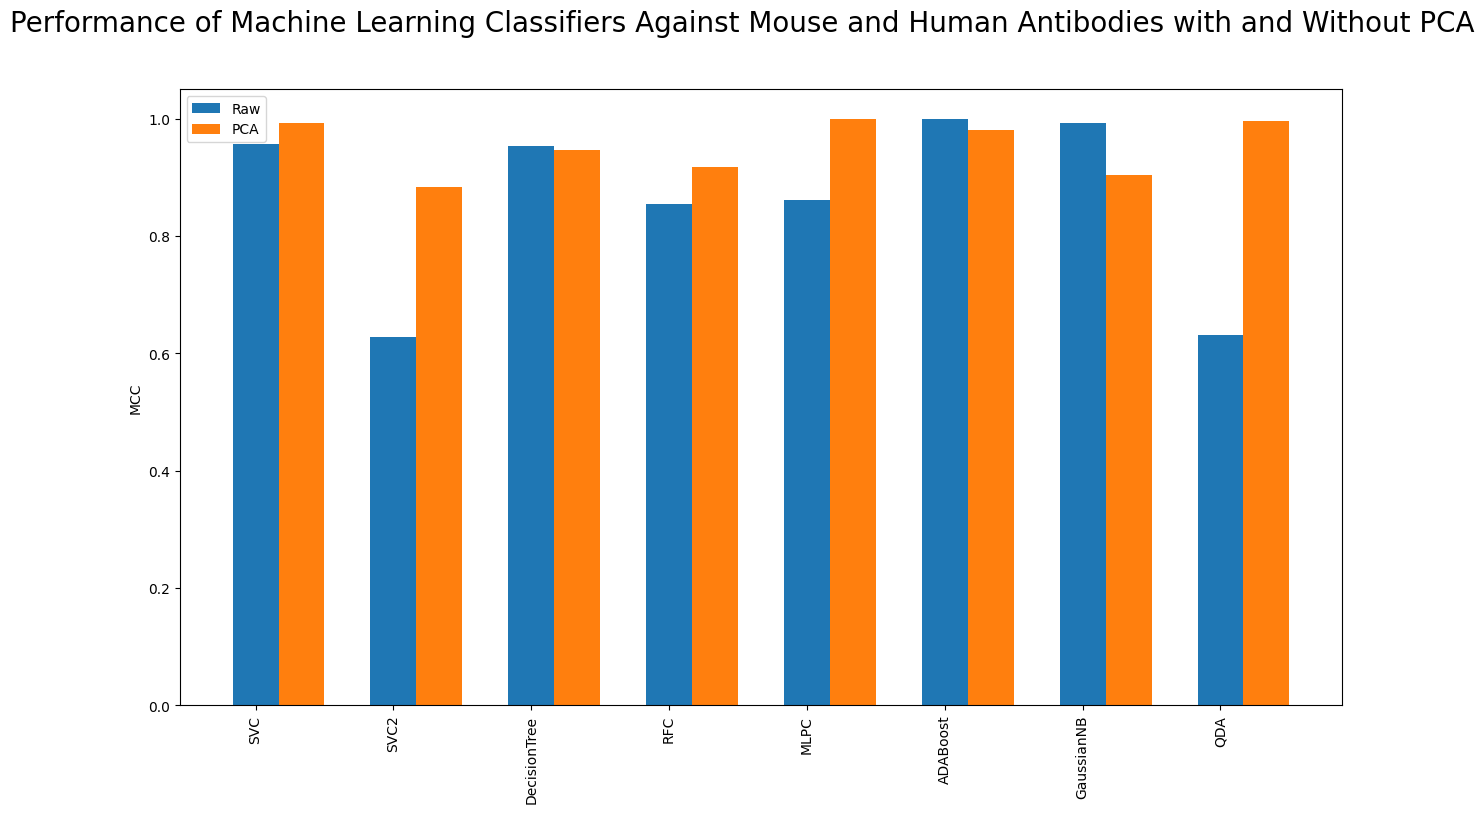

In [113]:
##Plot Score of Each Classifier Comparing Dataset with PCA and without PCA##
labels = list(classifiers.keys())
aranged = np.arange(len(classifiers)) 
width = 1/3
fig, ax = plt.subplots(figsize=(15,8))
bar1 = plt.bar(aranged, scores, width,label = 'Raw')
bar2 = plt.bar(aranged+width, scores_PCA , width,label = 'PCA')
plt.suptitle('Performance of Machine Learning Classifiers Against Mouse and Human Antibodies with and Without PCA', fontsize=20)
ax.set_ylabel('MCC')
ax.set_xticks(aranged, labels, rotation = 90)
ax.legend()
plt.show()

From the results classifiers improve performance (SVC, MLPC, QDA) with the PCA but this is not always the case (Decision Tree, RFC, ADABoost). 

The PCs themselves can be plotted against each other to demonstrate if the PCA has learned distinguishing features between the two classes of data. 

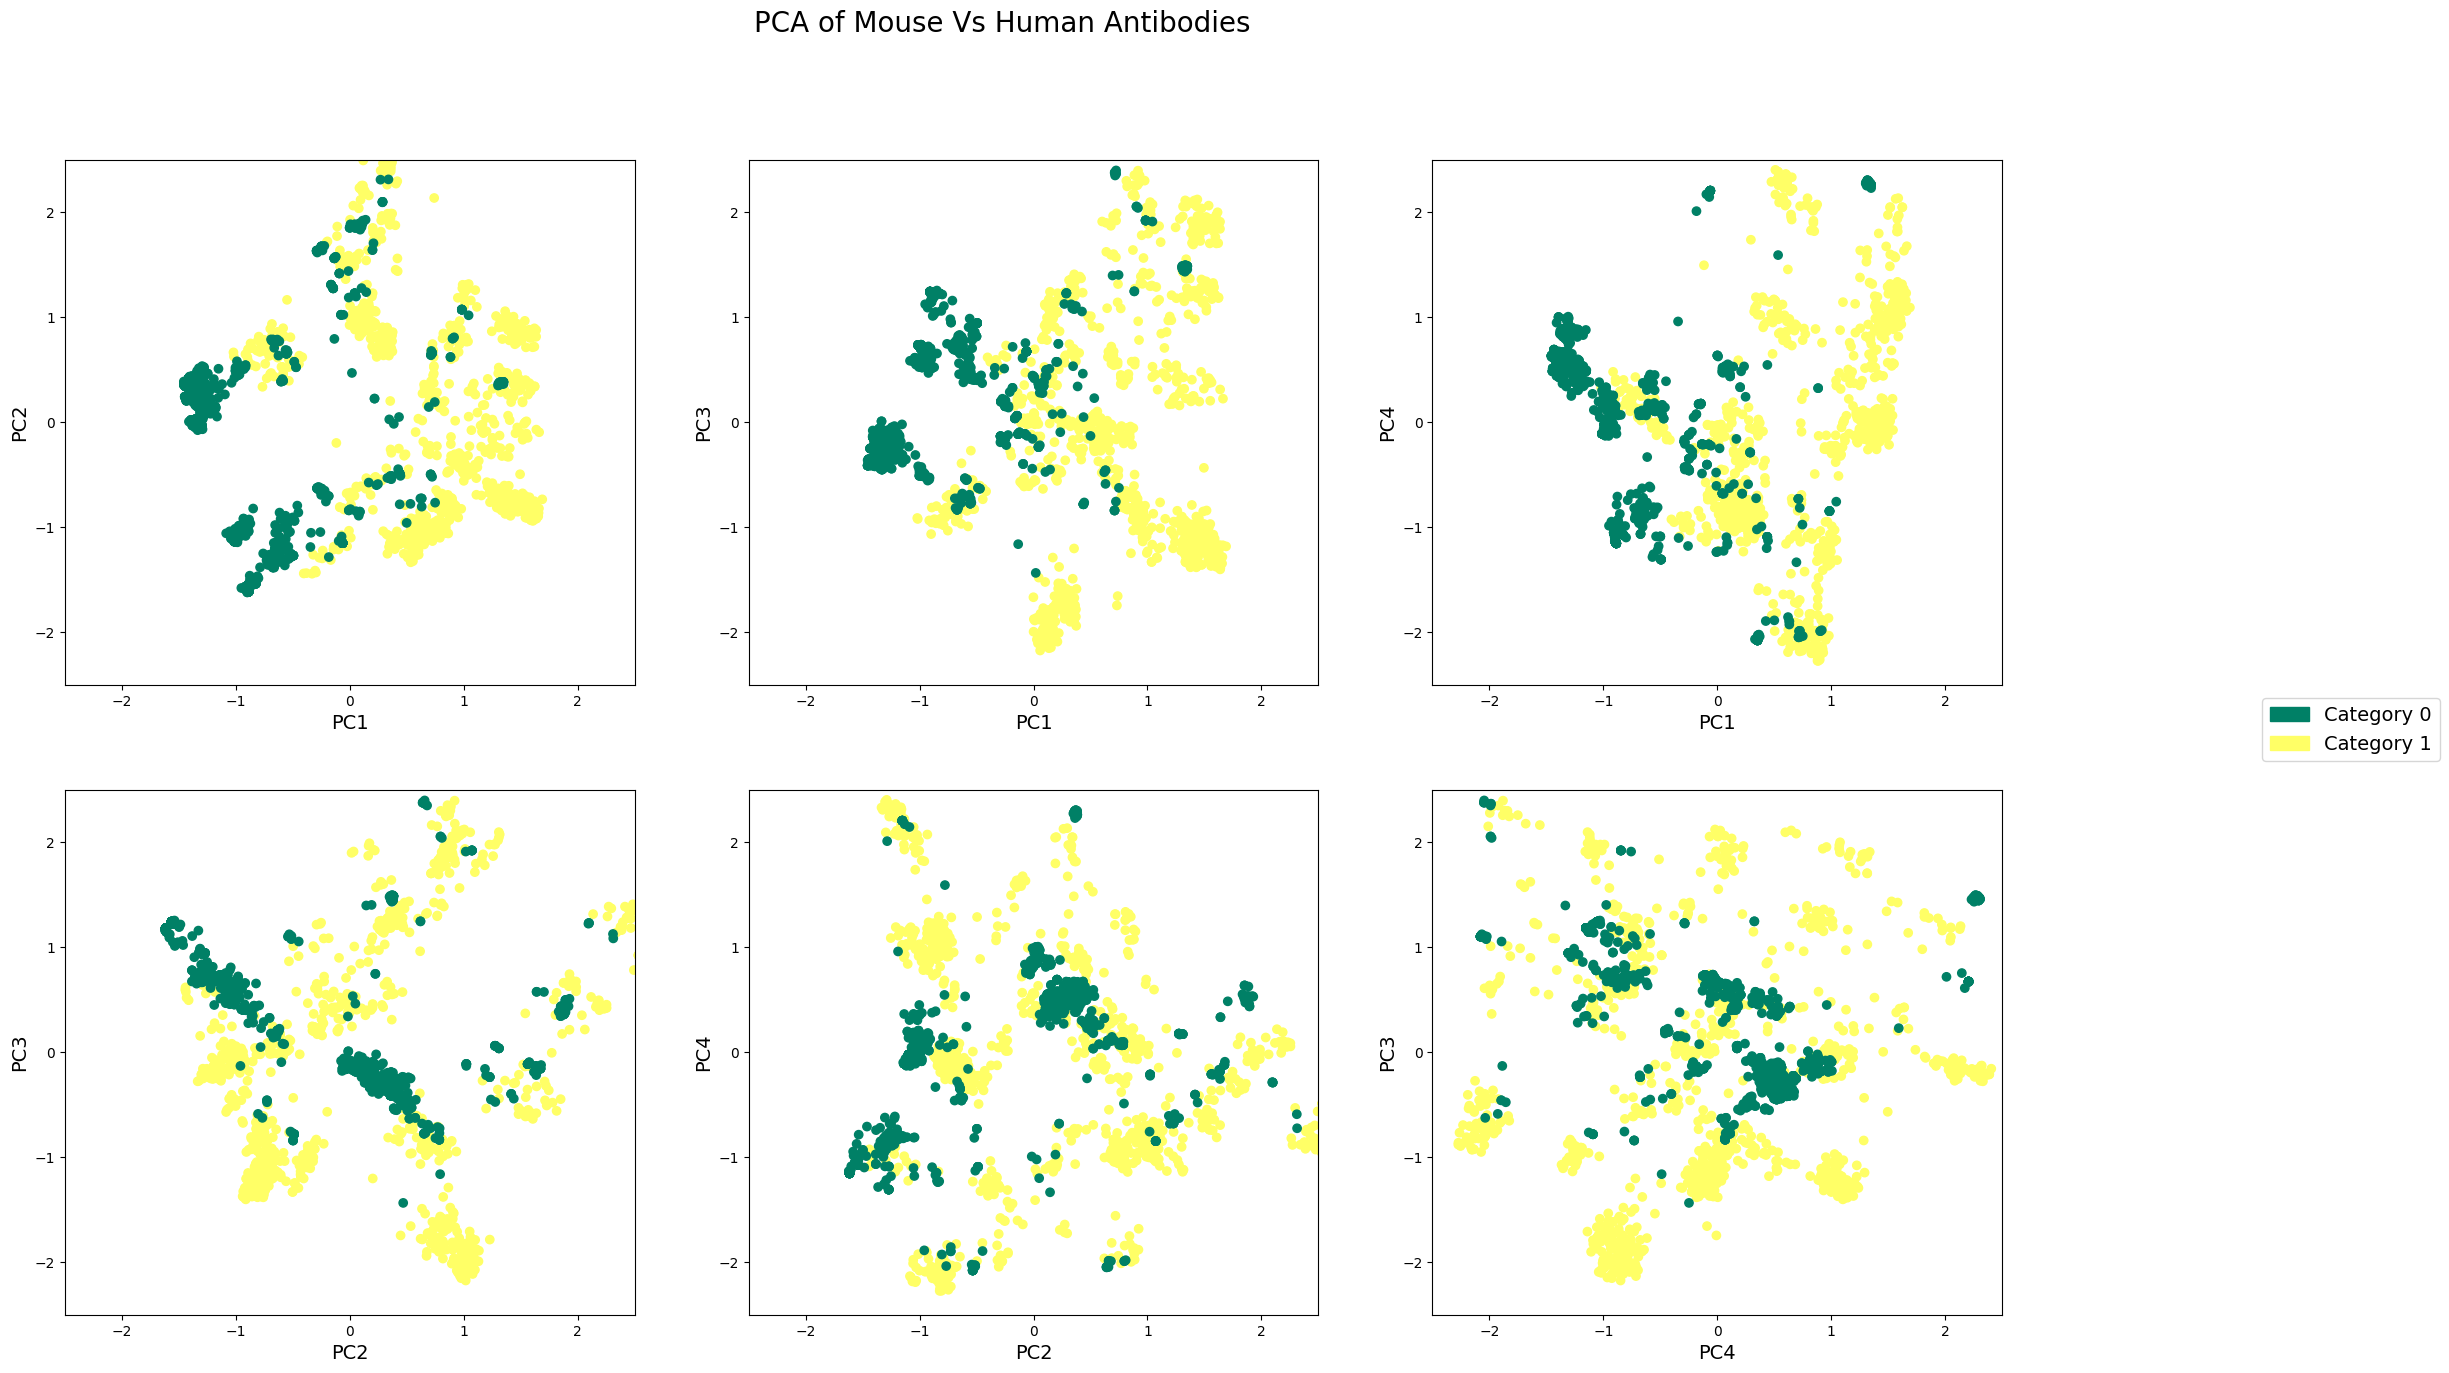

In [114]:
##Visualising Data Plot, plotting combinations of PC1 to PC4##
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(25, 15))
plt.suptitle('PCA of Mouse Vs Human Antibodies', fontsize=20)

categories = np.unique(y)
colors = plt.cm.summer(np.linspace(0, 1, len(categories)))

ax[0, 0].scatter(NewEncodingPCA[:,0], NewEncodingPCA[:,1], c=y, cmap='summer')
ax[0, 0].set_xlabel('PC1', fontsize=14)
ax[0, 0].set_xlim([-2.5,2.5])
ax[0, 0].set_ylabel('PC2', fontsize=14)
ax[0, 0].set_ylim([-2.5,2.5])


ax[0, 1].scatter(NewEncodingPCA[:,0], NewEncodingPCA[:,2], c=y, cmap='summer')
ax[0, 1].set_xlabel('PC1', fontsize=14)
ax[0, 1].set_xlim([-2.5,2.5])
ax[0, 1].set_ylabel('PC3', fontsize=14)
ax[0, 1].set_ylim([-2.5,2.5])


ax[0, 2].scatter(NewEncodingPCA[:,0], NewEncodingPCA[:,3], c=y, cmap='summer')
ax[0, 2].set_xlabel('PC1', fontsize=14)
ax[0, 2].set_xlim([-2.5,2.5])
ax[0, 2].set_ylabel('PC4', fontsize=14)
ax[0, 2].set_ylim([-2.5,2.5])


ax[1, 0].scatter(NewEncodingPCA[:,1], NewEncodingPCA[:,2], c=y, cmap='summer')
ax[1, 0].set_xlabel('PC2', fontsize=14)
ax[1, 0].set_xlim([-2.5,2.5])
ax[1, 0].set_ylabel('PC3', fontsize=14)
ax[1, 0].set_ylim([-2.5,2.5])


ax[1, 1].scatter(NewEncodingPCA[:,1], NewEncodingPCA[:,3], c=y, cmap='summer')
ax[1, 1].set_xlabel('PC2', fontsize=14)
ax[1, 1].set_xlim([-2.5,2.5])
ax[1, 1].set_ylabel('PC4', fontsize=14)
ax[1, 1].set_ylim([-2.5,2.5])


ax[1, 2].scatter(NewEncodingPCA[:,3], NewEncodingPCA[:,2], c=y, cmap='summer')
ax[1, 2].set_xlabel('PC4', fontsize=14)
ax[1, 2].set_xlim([-2.5,2.5])
ax[1, 2].set_ylabel('PC3', fontsize=14)
ax[1, 2].set_ylim([-2.5,2.5])
patches = [mpatches.Patch(color=colors[i], label=f'Category {categories[i]}') for i in range(len(categories))]

fig.legend(handles=patches, loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=14)






What can be observed from the plotted PCs is that the model has learned some features that can be used to separate the two groups in most cases. This can be seen most clearly in the PC1 plotted against PC2 plot. However, there is some crossover as some of the mouse antibodies (green) are plotted with human antibodies (yellow), and so the model still has to use a combination of features to learn differences between the two groups.

## Feature Selection 

Other methods of feature selection are available where an arbitrary number of features can be kept for use in training. F-regression is a technique that selects the n most relevant features to the target variable. This is done through calculating the corelation of each feature (X) to the labels (y) and then arranging them from highest to lowest. The top k features can be selected from this ranking. Below this technique is applied to the data and see how some poorly performing classifiers can be improved.


In [115]:
#Transform data to numpy arrays#
X_NUMPY, Y_NUMPY = dataset.to_numpy(),np.array(y)

#Define number of features to keep
features = 100

#Perform feature selection using f_regression
fs = SelectKBest(score_func=f_regression, k=features)
X_selected = fs.fit_transform(X_NUMPY, Y_NUMPY)

#Get Train/Test Split#
X_selected_train, X_selected_test, y_selected_train, y_selected_test = train_test_split(X_selected, y, test_size=.3, random_state=RANDOM_SEED, shuffle=True)

##Loop through classifiers and obtain MCC values of newly transformed datasets##
scores_F_regression = []
for i in classifiers:
    clf_1 = classifiers.get(i)
    clf_1.fit(X_selected_train,y_selected_train)
    y_predict = clf_1.predict(X_selected_test)
    scoring = matthews_corrcoef(y_selected_test, y_predict)
    scores_F_regression.append(scoring)



/Users/james/anaconda3/envs/py38-igfold/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


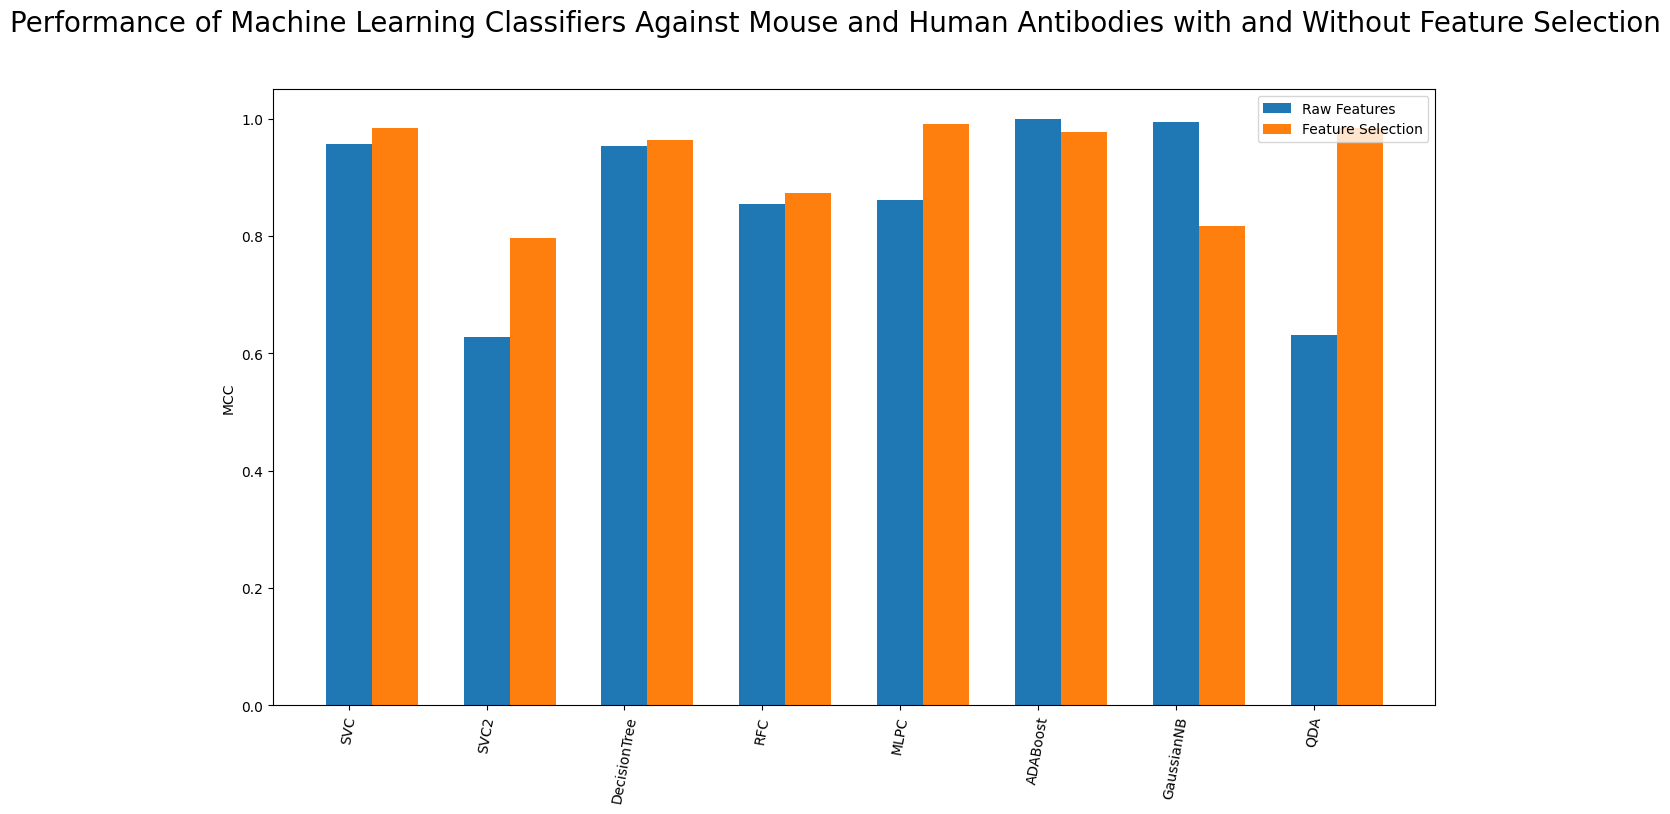

In [116]:

##Plot Score of Each Classifier Comparing Dataset with PCA and without PCA##
labels = list(classifiers.keys())
aranged = np.arange(len(classifiers)) 
width = 1/3
fig, ax = plt.subplots(figsize=(15,8))
bar1 = plt.bar(aranged, scores, width,label = 'Raw Features')
bar2 = plt.bar(aranged+width, scores_F_regression , width,label = 'Feature Selection')
plt.suptitle('Performance of Machine Learning Classifiers Against Mouse and Human Antibodies with and Without Feature Selection', fontsize=20)
ax.set_ylabel('MCC')
ax.set_xticks(aranged, labels, rotation = 80)
ax.legend()
plt.legend()
plt.show()

Certainly for the MLPC classifier and the QDA classifier, a significant increas in performance is observed. Take some time to consider the operation we just performed and how this has improved performance.

### Questions

- Does feature selection add or lose information?

- Why could feature selection increase the performance of the classifiers if this is the case?



## Using Deep Learning to Classify Human and Mouse Antibodies

Another approach that is available to data scientists is using deep learning models. This approach involves defining and building more complex models, artificial neural networks, that have several layers of nodes:
- an input layer which has a number of nodes equal to the number of features in the data.
- a series of hidden layers where the data is transformed as it progresses through the model according to weights set at each node and activation functions for learning patterns in the data.
- an output layer consisting of the number nodes desired.

The model is trained over a defined number of epochs, which are passes of the training dataset, where a loss value is obtained at the end of each epoch. This loss value is a measure of the difference between the model predictions of the training data and the truth. During each epoch, the weights of each node can be adjusted to achieve a lower loss function over time. These adjustments to weights can be done using optimizers to minimise the loss across successive epochs according to a set elarning rate. It is important not to train over too many epochs or to set a high learning rate as this could result in a model which is easily overfitted or which quickly reaches a local minimum and is not generalisable, and so it can be good practise to evaulate ranges of parameters. The model is evaluated with a test split dataset as seen before.


While this approach can build complex models, it is still better to take simple approaches using simple datasets. The deep learning model outlined below is designed with binary classification in mind. It is built with five hidden layers with varying numbers of neurons and uses the ReLU activation function to introduce non-linearity, allowing it to learn complex patterns in the data. Furthermore, the Adam optimiser was used for adjusting the weights over the training using gradients computed by backpropagation. The final layer has a single output node with a sigmoid function for binary classification and the loss function used here was binary cross-entropy, which is commonly used in these tasks. The model is trained over 50 epochs with a learning rate of 0.001.



In [117]:
##Import deep learning modules from Pytorch##
import torch
import torch.nn as nn
import torch.optim as optim

#Load Data and split into training and testing sets#
joined_dataframe_VH_VL = read_csv('./Human_Mouse_VH_VL_OHE.csv', header = 0)
dataset = joined_dataframe_VH_VL
dataset=dataset.loc[:, dataset.columns != 'Unnamed: 0']

#Get Train/Test Split#
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=.3, random_state=RANDOM_SEED, shuffle=True)
num_rows, num_cols = dataset.shape
print("Training set size: ", X_train.shape, "       Test set size: ", X_test.shape)

#Convert data to Pytorch tensors#
X_train_pt = torch.tensor(X_train.values, dtype=torch.float32)
X_test_pt = torch.tensor(X_test.values, dtype=torch.float32)
y_train_pt = torch.tensor(y_train ,dtype=torch.float32).view(-1, 1)
y_test_pt = torch.tensor(y_test, dtype=torch.float32)

Training set size:  (1400, 3738)        Test set size:  (600, 3738)


In [118]:
#Define Simple Binary Classification Model#
class Deep_Learning_Model(nn.Module):
    
    def __init__(self, input_size):
        super(Deep_Learning_Model, self).__init__()
        self.layer1 = nn.Linear(input_size, 512) 
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = self.sigmoid(self.layer5(x))
        return x

#Initialise model, criterion and optimizer#
learning_rate = 0.001
model = Deep_Learning_Model(X_train.shape[1])
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Epoch [10/50], Loss: 0.1363
Epoch [20/50], Loss: 0.0000
Epoch [30/50], Loss: 0.0000
Epoch [40/50], Loss: 0.0000
Epoch [50/50], Loss: 0.0000


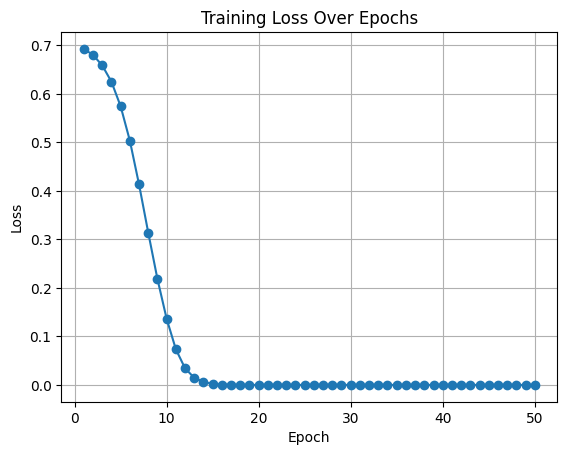

In [119]:
#Train deep learning model over a set number of epochs#
epochs = 50
loss_values = []

for epoch in range(epochs):
    model.train()
    
    #Calculate loss function#
    outputs = model(X_train_pt)
    loss = loss_function(outputs, y_train_pt)
    loss_values.append(loss.item())

    #Update weights#
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Print the loss every 10 epochs#
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

#Save final state model#
torch.save(model.state_dict(), 'binary_classification_model.pth')

#Plot Loss Function Over Epochs#
plt.plot(range(1, epochs+1), loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()


Matthews Correlation Coefficient: 0.9900


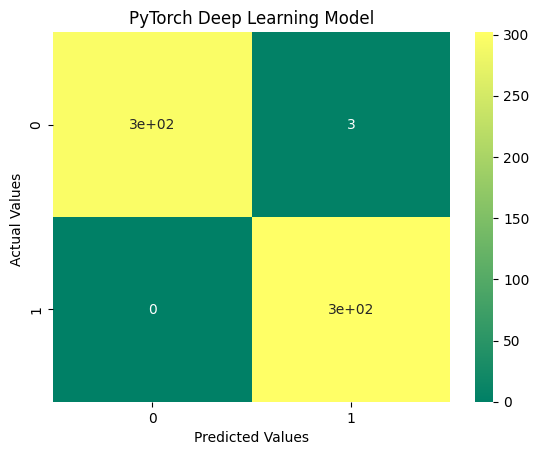

In [120]:
#Load final state model#
model.load_state_dict(torch.load('binary_classification_model.pth'))

#Evaluate model with test data#
model.eval()
with torch.no_grad():
    predictions = model(X_test_pt)

# Convert predictions to binary (0 or 1)
predicted_labels = torch.round(torch.sigmoid(predictions)).squeeze().numpy()
cf_matrix = metrics.confusion_matrix(y_test_pt.numpy(), predicted_labels)
# Calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test_pt.numpy(), predicted_labels)
print(f'Matthews Correlation Coefficient: {mcc:.4f}')


confusion_matrix = metrics.confusion_matrix(y_test_pt.numpy(), predicted_labels)
ax = sns.heatmap(confusion_matrix, annot=True, cmap='summer')
ax.set_title('PyTorch Deep Learning Model')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')

plt.show()
    

Overall, this model performed very well with the One Hot Encoded amino acid sequences. It is observed that the loss function decreases appropriately across epochs and for the test split of the data, very high MCC score is observed. 

- Would this model architecture be suitable for the sequences encoded with physicochemical properties?

- What might need to be changed?

## End of Chapter Exercise

We have seen that it is possible to separate mouse and human antibody protein sequences through their numerical encodings. But what if we wanted to separate antibody sequences from more species? Included in this worksheet is a dataset of 1000 rat antibodies, as well as the previously used 1000-entry human and mouse datasets. On your own, try to generate additional classifieres to separate increasing combinations of species (*i.e.* human versus rat, and mouse versus rat). Use any of the hyperparameterisation techniques that we have learned, as you see fit. 

- Report which of these classifiers was the easiest to build.

- Give reasons why some of these classifiers may be difficult to build.

## Summary

This workbook should have demonstrated methods of improving the performance of machine learning predictors using hyperparameterisation, data transformation and feature selection to obtain the best results.

## Keypoints

- It is sometimes necessary to experiment with different machine learning classifiers or hyperparameterisation techniques, to achieve the best prediction results.

- It is possible to use feature selection to understand tangible differences in the data which are important for the classification.


 